<a href="https://colab.research.google.com/github/robertoricci/Analise-Financeira/blob/main/20240229_ancoragem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introdução

Expectativas ancoradas significa que a taxa de inflação corrente é mantida em um valor próximo da meta, inclusive após a ocorrência de choques relevantes. Isso é importante para a economia pois torna mais previsível a evolução temporal da inflação no país, além de fazer com que a ação do Banco Central no combate a pressões inflacionárias seja menos custosa.

Se expectativas de inflação ancoradas com a meta é importante para a economia, analisar o grau de ancoragem é imperativo para economistas e analistas de mercado. Neste exercício mostramos uma forma de aplicar esta análise com uma metodologia desenvolvida pelo FMI. Desde a coleta dos dados, passando pelo modelo e pela visualização de dados, mostramos como analisar a política monetária usando o Python.

## Método de análise

Expectativas de inflação ancoradas significam que o valor dessas expectativas estejam, no horizonte relevante, próximo da meta de inflação ou mesmo constantes durante o período de referência, principalmente a do ano corrente, que tem efeito sobre os horizonte futuros. Entretanto, quando há a ocorrência de mudanças súbitas nos valores das expectativas de inflação, temos portanto, surpresas inflacionárias, e consequentemente a desancoragem de expectativas.

Para estimar uma medida de sensibilidade a surpresas inflacionárias, devemos verificar o impacto que variações nas expectativas para o ano corrente provocam sobre as expectativas para prazos mais longos. Na presença de expectativas bem ancoradas, deve haver baixa relação (co-movimento) entre as expectativas de inflação de longo prazo e as de curto prazo, em que estas últimas capturariam surpresas inflacionárias.

Em termos econométricos, essa sensibilidade é calculada a partir do coeficiente $\beta$, de acordo com a equação abaixo:

$$\Delta \pi_t^{e,h} = \alpha + \beta^h \Delta \pi_t^{e,0} + \epsilon_t$$

onde $\Delta \pi_{t}^{e,h}$ é a variação $\Delta$ da expectativa de inflação $\pi^e$ no tempo $t$ para o horizonte $h = 1, ... , 4$, em anos, para o qual foram formadas as expectativas.

Portanto, quanto maior o coeficiente $\beta$ menos ancoradas as expectativas, ou seja, maior a resposta das expectativas de longo prazo a surpresas inflacionárias. Como o interesse é na evolução deste coeficiente ao longo do tempo, as estimações são realizadas a partir de janelas móveis de 60 meses.

## Dados

O Boletim Focus permite extrair as expectativas de agentes para diferentes horizontes de diferentes indicadores, incluindo o IPCA, medida oficial de inflação no Brasil. A cada período de tempo, os agentes divulgam os valores que entendem que será o indicador no futuro em diferentes horizontes, e que tal valor, obviamente se altera, devido a mudanças de condições da economia. O Banco Central do Brasil (BCB) disponibiliza uma API para baixar os dados.

## Exercício aplicado no Python

Para a construção do exercício utilizamos o Python, seguindo etapas relativas ao processo de análise de dados. Estas etapas são:

1. Carregamento das bibliotecas do Python;
2. Coleta e tratamento dos dados das expectativas de inflação anuais;
3. Especificação e ajuste do modelo econométrico em janelas deslizantes de 60 meses;
4. Visualização do coeficiente $\beta$ extraído do modelo.

A partir das etapas acima, temos como resultado o gráfico ao final, que demonstra o coeficiente $\beta$ estimado, ou seja, medida de sensibilidade a surpresas inflacionárias.

### 1. Carregamento das bibliotecas

In [ ]:
!pip install python-bcb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 84.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.21.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.1 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.2.1 which is incompatible.


In [ ]:
from bcb import Expectativas
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from plotnine import *

### 2.  Coleta e Tratamento de dados

Vamos coletar as expectativas anuais do IPCA. Em seguida, devemos definir os horizontes com base na data de referência. Retiramos a média do valor da mediana para os respectivos meses agrupados por horizontes. E por fim, obtemos o delta de cada horizonte, isto é, a diferença entre o valor do horizonte no tempo t e do tempo t-1.

In [ ]:
# Instância a classe de Expectativas
em = Expectativas()

# Obtém o endpoint da Expectativa de Mercado Anuais
exp_ipca_endpoint = em.get_endpoint("ExpectativasMercadoAnuais")

# Expectativa média do IPCA - tx. anual (Expectativas)
exp_ipca_raw = (
    exp_ipca_endpoint
    .query()
    .filter(exp_ipca_endpoint.baseCalculo == 0,
            exp_ipca_endpoint.Indicador == "IPCA",
            exp_ipca_endpoint.Data >= "2002-01-01")
    .collect()
    )
exp_ipca_raw

,Indicador,IndicadorDetalhe,Data,DataReferencia,Media,Mediana,DesvioPadrao,Minimo,Maximo,numeroRespondentes,baseCalculo
0,IPCA,None,2002-01-02,2001,7.3700,7.4100,0.1400,6.5000,7.63,NaN,0
1,IPCA,None,2002-01-02,2002,4.8100,4.7500,0.5800,3.6600,6.65,NaN,0
2,IPCA,None,2002-01-02,2003,4.0100,4.0000,0.5600,3.0000,5.50,NaN,0
3,IPCA,None,2002-01-02,2004,3.6900,3.5000,0.6900,3.0000,5.50,NaN,0
4,IPCA,None,2002-01-02,2005,3.4600,3.2500,0.6900,2.0000,5.00,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
27780,IPCA,None,2024-02-23,2024,3.7838,3.8000,0.2960,2.9563,5.04,152.0,0
27781,IPCA,None,2024-02-23,2025,3.5805,3.5145,0.3617,3.0000,5.10,145.0,0
27782,IPCA,None,2024-02-23,2026,3.4987,3.5000,0.4729,2.7500,6.50,127.0,0
27783,IPCA,None,2024-02-23,2027,3.4524,3.5000,0.4079,2.8000,5.00,117.0,0


In [ ]:
exp_ipca_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27785 entries, 0 to 27784
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Indicador           27785 non-null  object        
 1   IndicadorDetalhe    0 non-null      object        
 2   Data                27785 non-null  datetime64[ns]
 3   DataReferencia      27785 non-null  object        
 4   Media               27785 non-null  float64       
 5   Mediana             27785 non-null  float64       
 6   DesvioPadrao        27785 non-null  float64       
 7   Minimo              27785 non-null  float64       
 8   Maximo              27785 non-null  float64       
 9   numeroRespondentes  12725 non-null  float64       
 10  baseCalculo         27785 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(1), object(3)
memory usage: 2.3+ MB


In [ ]:
# Realiza a filtragem e define os horizontes
exp_ipca_h = (
    exp_ipca_raw
    .filter(items = ["Data", "DataReferencia", "Mediana"], axis = "columns")
    .assign(
      DataReferencia = lambda x: x.DataReferencia.astype(int),
      h = lambda x: np.select([
        x["Data"].dt.year == x["DataReferencia"],
        x["Data"].dt.year == x["DataReferencia"] - 1,
        x["Data"].dt.year == x["DataReferencia"] - 2,
        x["Data"].dt.year == x["DataReferencia"] - 3,
        x["Data"].dt.year == x["DataReferencia"] - 4
        ],
        ["h0", "h1", "h2", "h3", "h4"]
        )
    )
    .query("h != '0'")
)
exp_ipca_h

,Data,DataReferencia,Mediana,h
1,2002-01-02,2002,4.7500,h0
2,2002-01-02,2003,4.0000,h1
3,2002-01-02,2004,3.5000,h2
4,2002-01-02,2005,3.2500,h3
6,2002-01-03,2002,4.7500,h0
...,...,...,...,...
27780,2024-02-23,2024,3.8000,h0
27781,2024-02-23,2025,3.5145,h1
27782,2024-02-23,2026,3.5000,h2
27783,2024-02-23,2027,3.5000,h3


In [ ]:
# Agrega dados
expec_ipca = (
     exp_ipca_h
    .assign(data = lambda x: x.Data.dt.to_period(freq = "M").dt.to_timestamp())
    .groupby(by = ["data", "h"], as_index = False)
    .agg(Mediana = ("Mediana", "mean"))
  )
expec_ipca

,data,h,Mediana
0,2002-01-01,h0,4.750455
1,2002-01-01,h1,4.000000
2,2002-01-01,h2,3.561818
3,2002-01-01,h3,3.403636
4,2002-01-01,h4,3.556000
...,...,...,...
1325,2024-02-01,h0,3.813040
1326,2024-02-01,h1,3.510907
1327,2024-02-01,h2,3.500000
1328,2024-02-01,h3,3.500000


In [ ]:
# Calcula o delta (diferença do tempo t com o tempo t-1)
expec_ipca_diff = (
    expec_ipca
    .pivot(index = "data", columns = "h", values = "Mediana")
    .diff()
    .dropna()
  )
expec_ipca_diff

h,h0,h1,h2,h3,h4
data,,,,,
2002-02-01,0.063756,0.000000,-0.054976,0.096364,-0.056000
2002-03-01,0.145289,0.000000,0.075158,0.000000,0.000000
2002-04-01,0.389591,0.000000,0.040727,0.000000,0.000000
2002-05-01,0.115671,0.000000,-0.058442,0.000000,0.000000
2002-06-01,0.020238,0.000000,-0.064286,0.000000,0.000000
...,...,...,...,...,...
2023-10-01,-0.146078,0.016805,0.000000,0.000000,0.000000
2023-11-01,-0.164927,0.030725,0.000000,0.000000,0.000000
2023-12-01,-0.082035,0.004395,0.000000,0.000000,0.000000


### 3. Criação do Modelo

Para obter o coeficiente $\beta$ em janelas deslizantes de 60 meses será necessário utilizar a função `RollingOLS` da biblioteca `statsmodels`.

Em relação a especificação, podemos obter a surpresa inflacionária para os diferentes horizontes, portanto, para obter o resultado de todas as combinações possíveis, usaremos um `for loop` para as fórmulas.

In [ ]:
# Define variável independente e variáveis dependentes
X = expec_ipca_diff["h0"]
Y_cols = ["h1", "h2", "h3", "h4"]

# Define tamanho da janela de regressão
k = 60

# Cria lista para armazenar os resultados das regressões
results = []

# Loop para ajustar os modelos de regressão
for col in Y_cols:
    # Define fórmula da regressão
    formula = f"{col} ~ h0"

    # Cria o objeto RollingOLS
    model_rolling = RollingOLS.from_formula(
      formula = formula,
      data = expec_ipca_diff,
      window = k
      )

    # Calcula as rolling regressions
    rolling_res = model_rolling.fit()

    # Salva os resultados das regressões
    results.append(rolling_res.params)

# Juntar os resultados das regressões em um único dataframe
results_df = pd.concat(results, axis = 0, keys = Y_cols)

# Captura somente o beta da regressão
beta = (
    results_df
    .reset_index()
    .rename(columns = {"level_0": "variables", "h0" : "beta"})
    .dropna()
    .filter(items = ["data", "variables", "beta"], axis = "columns")
    .assign(
      variables = lambda x: x.variables.case_when([
        (x.variables == "h1", "Expectativa 1 ano"),
        (x.variables == "h2", "Expectativa 2 anos"),
        (x.variables == "h3", "Expectativa 3 anos"),
        (x.variables == "h4", "Expectativa 4 anos"),
      ])
    )
)
beta

,data,variables,beta
59,2007-01-01,Expectativa 1 ano,0.602037
60,2007-02-01,Expectativa 1 ano,0.602117
61,2007-03-01,Expectativa 1 ano,0.602447
62,2007-04-01,Expectativa 1 ano,0.605620
63,2007-05-01,Expectativa 1 ano,0.605380
...,...,...,...
1055,2023-10-01,Expectativa 4 anos,0.008422
1056,2023-11-01,Expectativa 4 anos,0.008448
1057,2023-12-01,Expectativa 4 anos,0.008510
1058,2024-01-01,Expectativa 4 anos,0.008202


### 4. Visualização de dados

Enfim podemos visualizar o coeficiente $\beta$ para cada horizonte ao longo de diferentes mandatos de presidentes do Banco Central e realizar uma análise.

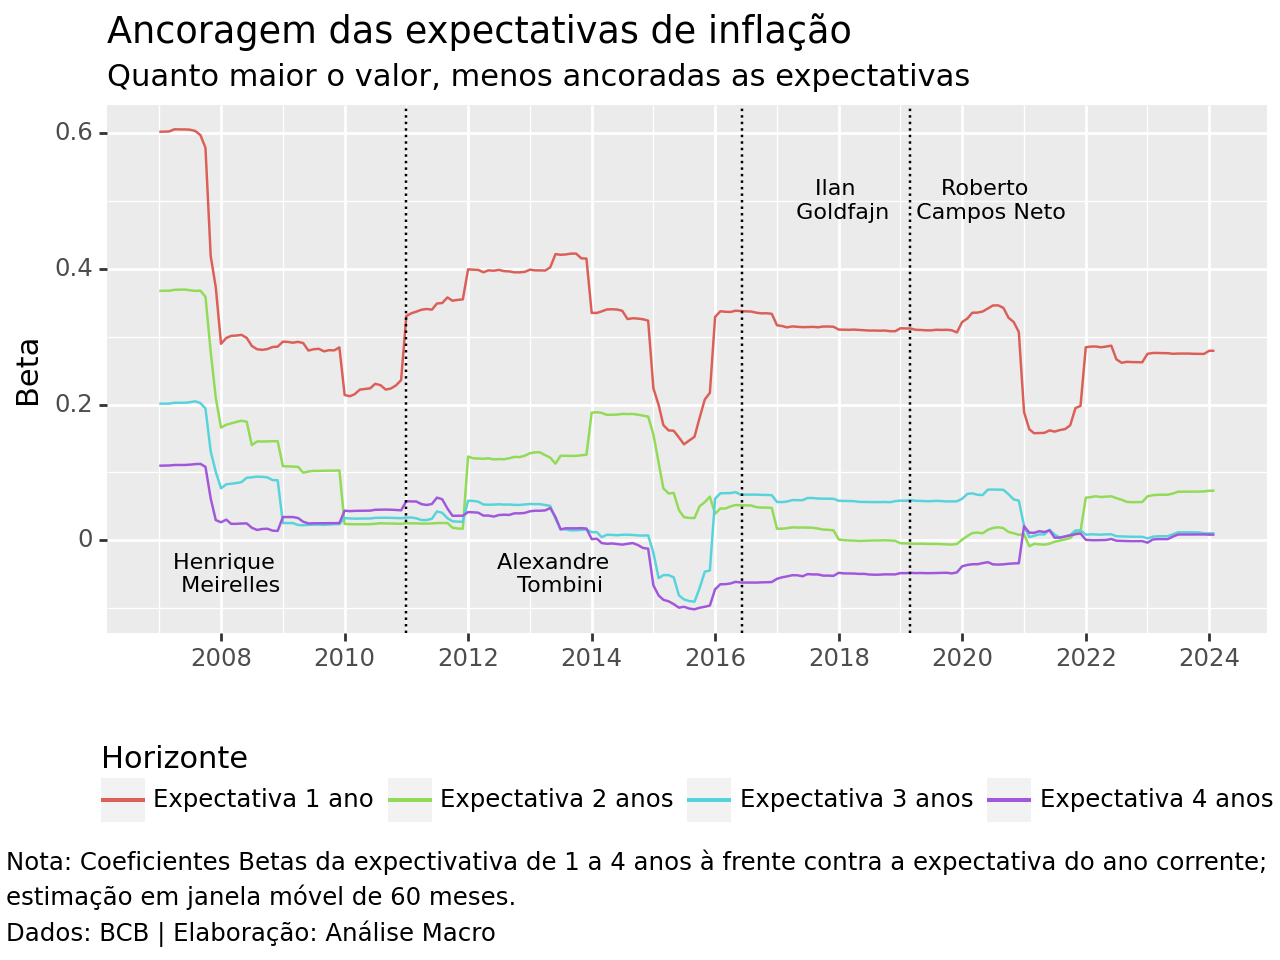

<Figure Size: (640 x 480)>

In [ ]:
# Criação do gráfico
(
  ggplot(beta) +
  aes(x = "data", y = "beta", color = "variables") +
  geom_line() +
  scale_x_date(date_breaks = "2 years", date_labels = "%Y") +
  geom_vline(
    xintercept = ["2010-12-31", "2016-06-09", "2019-02-28"],
    linetype = "dotted"
    ) +
  annotate(
    geom = "text",
    x = "2008-02-09",
    y = -0.05,
    label = "Henrique \n Meirelles",
    size = 8
    ) +
  annotate(
    geom = "text",
    x = "2013-06-09",
    y = -0.05,
    label = "Alexandre \n Tombini",
    size = 8
    ) +
  annotate(
    geom = "text",
    x = "2018-01-01",
    y = 0.5,
    label = "Ilan \n Goldfajn",
    size = 8
    ) +
  annotate(
    geom = "text",
    x = "2020-06-01",
    y = 0.5,
    label = "Roberto \n Campos Neto",
    size = 8
    ) +
  labs(
    title = "Ancoragem das expectativas de inflação",
    subtitle = "Quanto maior o valor, menos ancoradas as expectativas",
    color = "Horizonte",
    x = "",
    y = "Beta",
    caption = (
      "Nota: Coeficientes Betas da expectivativa de 1 a 4 anos à frente contra a expectativa do ano corrente;\nestimação em janela móvel de " + str(k) + " meses.\n" +
      "Dados: BCB | Elaboração: Análise Macro"
      )
    ) +
  theme(
    legend_position = "bottom",
    legend_box_margin = 5,
    plot_caption = element_text(linespacing = 1.5)
    )
)